# Assignment 01 - Pitfalls in Data Mining     
## CSCI E-96

The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls which lead to incorrect inferences.   

In this assignment you will gain a bit of experience with three important concepts in data mining:  

1. **False Discovery Rate Control:** The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls of incorrect inference, **false discovery**. A related problem is cutting off a large-scale analysis when a desired relationship is 'found'. This practice of **p-value mining** often leads to unwarranted inferences. You will apply false discovery rate (FDR) control methods to address this problem.   
2. **Key-Value Pairs:** Large scale data is typically managed using key-value (KV) pairs. The exercises in this assignment give you some experience working with KV pair data management.  
3. **Map and Reduce Processes:** Much of large scale data mining requires use of a split-apply-combine approach. The data is split into manageable chunks, analytic transformations are applied, and the result combined or aggregated. A commonly used class of a split-apply-combine algorithm is MapReduce. 

In order to keep the scope of this assignment manageable, you will use limited versions of KV pair management and MapReduce. Specifically, you will use common Python tools to implement these concepts rather than dedicated large scale analytic platforms. 

## Multiple Hypothesis Tesing

Testing multiple hypothesis in high-dimensional data is problematic. Exhaustively testing all pairwise relationships between variables in a data set is a commonly used, but generally misleading, from of **multiple comparisons**. The chance of finding false significance, using such a **data dredging** approach, can be surprisingly high. 

In this exercise you will perform multiple comparisons on **only 20 identically distributed independent (iid)** variables. Ideally, such tests should not find significant relationships, but the actual result is quite different. 

To get started, execute the code in the cell below to load the required packages. 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from scipy.stats import ttest_ind, f_oneway
from itertools import product, combinations
from math import comb
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

pd.set_option("display.max_rows", None, "display.max_columns", None)

In this exercise you will apply a [t-test](https://www.statisticshowto.com/probability-and-statistics/t-test/) to all pairwise combinations of identical Normally distributed variables. In this case, we will create a data set with 20 iid Normal distributions of 1000 samples each. Execute the code in the cell below to find this data and display the mean and variance of each variable.  

In [2]:
ncolumns = 20
nr.seed(234)
normal_vars = nr.normal(size=(1000,ncolumns))
print('The means of the columns are\n', np.mean(normal_vars, axis = 0))
print('\nThe variances of the columns are\n', np.var(normal_vars, axis = 0))

The means of the columns are
 [-1.16191649e-01  2.80829317e-02 -1.78516419e-02 -1.44691489e-02
  3.03718152e-02  1.20007442e-02 -9.58845606e-05  1.98662580e-03
  4.94154934e-02 -4.11640866e-02 -6.32977862e-03 -5.93868192e-02
 -2.56373595e-02  1.43568791e-02 -1.44725765e-02 -1.37023955e-02
  1.80622439e-02  5.87029691e-02 -2.02650514e-02 -1.56346106e-02]

The variances of the columns are
 [0.94834508 1.04744241 1.0258018  0.96977571 1.0089001  1.04113864
 1.00657222 0.99192594 1.04713487 1.04329434 1.04023108 0.96791346
 1.03706907 1.07179865 1.01431404 1.05060289 1.02054329 0.9686211
 1.02810287 0.99521555]


In [3]:
count = 0
alpha = 0.05
for i in range(ncolumns-1):
    for j in range(i+1, ncolumns):
        result = ttest_ind(normal_vars[:, i], normal_vars[:,j])
        if result[1] < alpha:
            count += 1
            # print(result[1])
print(str(count) + ' t-tests are significant at an alpha of ' + str(alpha))


22 t-tests are significant at an alpha of 0.05


Notice that means and variances are close to 0.0 and 1.0 respectively. As expected, there is not much difference between these variables.

How many of these t-tests will show **significance** at the 0.05 cut-off level? With 20 variables there are 190 unique pairwise combinations. We expect to find a number of falsely significant test results from this many pairwise tests. 

## Creating a hash 

The goal of this exercise is to compute pairwise hypothesis tests of the differences in means for each of the iid Normal vectors. As an intermediate step you will create a Pandas data frame using a hash of the keys of the vectors. The data frame will contain the **key-value**, $(K,V)$, pairs. Each key must represent an index for the two vectors used to compute the test statistic. The keys will then be used to index the results of these hypothesis tests. 

The question is, how can we create a hash from the keys for the pair of vectors? In this case to we will use a simple, but far from optimal hash. For the two vector indicies $i, j$, for some key and modulo, $m$, we will compute the hash as:  

$$h(i,j) = (i + key*j) mod\ m$$

> **Exercise 1-1:** Given that our space of vectors is actually quite small, just 20, we do not need a sophisticated and scalable hash function. This hashed key will then be used to store and retrieve the values using the indicies of a Pandas data frame, in about $O(N)$ time.     

> In this exercise you will test a simple hash function and its inverse. Examine the code below and notice that the hash function encodes the two indexes into a single integer by simple additional and multiplication. The modulo operation limits the size of the hash table. However, to keep things simple you will not need to implement any hash collision resolution mechanism. As a result, the size of the table is set much larger than required.  

> To test this hash, do the following:    
> 1. Create a function called hash function to compute the hash. The arguments to the function are $i$ and $j$, the $hash\_key$ and the $modulo\_multiplier$. The defaults of the arguments are $hash\_key=1024$ and $modulo\_multiplier=32$. The modulo number is $hash\_key * modulo\_multiplier$, e.g. $modulo = 32,768$. The multiplier is the ratio of expected values stored, $n$, to the number of unique hash keys, $m$, e.g. the ratio $m/n$.
> 2. Using the Python [ittertools.combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) function create all unique pairwise combinations of indexes i and j. The arguments to this function are the indexes to the iid Normal vectors. The iterator is `range(ncolumns)` choose 2, since these comparisons are pairwise.    
> 3. Within this loop call the hash with the values of $i$ and $j$ as arguments.   
> 3. On a single line print the following; the values of i and j, the hash key value, but only if $i \le 6$. The restriction is to keep the printed output shorter.   

In [3]:
def hash_function(i, j, hash_key=128, modulo_multiplier=32):
    ## Put your code below. 
    return (i + j * hash_key) % (hash_key * modulo_multiplier)
    


for i,j in combinations(range(ncolumns), 2):
    if i < 3: 
        hash = hash_function(i,j)
        print('i = ' + str(i) + '  j = ' + str(j) + '   hash = ' + str(hash))

i = 0  j = 1   hash = 128
i = 0  j = 2   hash = 256
i = 0  j = 3   hash = 384
i = 0  j = 4   hash = 512
i = 0  j = 5   hash = 640
i = 0  j = 6   hash = 768
i = 0  j = 7   hash = 896
i = 0  j = 8   hash = 1024
i = 0  j = 9   hash = 1152
i = 0  j = 10   hash = 1280
i = 0  j = 11   hash = 1408
i = 0  j = 12   hash = 1536
i = 0  j = 13   hash = 1664
i = 0  j = 14   hash = 1792
i = 0  j = 15   hash = 1920
i = 0  j = 16   hash = 2048
i = 0  j = 17   hash = 2176
i = 0  j = 18   hash = 2304
i = 0  j = 19   hash = 2432
i = 1  j = 2   hash = 257
i = 1  j = 3   hash = 385
i = 1  j = 4   hash = 513
i = 1  j = 5   hash = 641
i = 1  j = 6   hash = 769
i = 1  j = 7   hash = 897
i = 1  j = 8   hash = 1025
i = 1  j = 9   hash = 1153
i = 1  j = 10   hash = 1281
i = 1  j = 11   hash = 1409
i = 1  j = 12   hash = 1537
i = 1  j = 13   hash = 1665
i = 1  j = 14   hash = 1793
i = 1  j = 15   hash = 1921
i = 1  j = 16   hash = 2049
i = 1  j = 17   hash = 2177
i = 1  j = 18   hash = 2305
i = 1  j = 19   hash =

> Examine the key pairs and the hash values. The question is, are there any hash collisions? This can be done as follows:   
> 5. Compute a list of the hash values for all combinations of $i$ and $j$.   
> 6. Print the length of the list.  
> 7. Print the length of the unique values of the hash. You can find the unique values in a list with the [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function. 

In [4]:
## Put your code below. 
hash_values = []
for i,j in combinations(range(ncolumns), 2):
    if i < 3: 
        hash_values.append(hash_function(i,j))

print('The number of hash values is ' + str(len(hash_values)))
print('The number of unique hash values is ' + str(len(np.unique(hash_values))))



The number of hash values is 54
The number of unique hash values is 54


> Examine the results you have printed. Is there any evidence of hash key collisions?  
>  
> The ratio of $m/n$ is deliberately kept high since the simple hash function has no collision resolution mechanism. Optionally, you can try reducing this ration (the multiplier) to 16 and 8, noting the increase in hash collisions.  
> **End of exercise.**

> **Answer:** Given that the results above indicate that all the hash values are unique, there is no evidence of hash collisions for this set of keys. 

## A MapReduce Example   

In the following steps you will use a simplified MapReduce framework to find and sort every possible pairwise t-test result for the `normal_vars` table. To do so you must find all **combinations** of keys, ${i,j}. The MapReduce processes you will create, are intended to create a table of these unique pairwise key combinations. The t-test is then computed from the values in the `normal_vars` table in the Reduce process. This MapReduce process only creates the required key combinations. The values remain in the `normal_vars` table. This approach simplifies some of the bookkeeping.     

In a bit more details the steps for this algorithm are:   
- The **Map process** builds a hash table with the hash of i,j as key and i,j as values. As has been noted most of this hash table will contain NaNs. Please don't be confused by the switching roles of i,j as they act as keys and values at different times.   
- The **Shuffle** scans the hash table for non-empty rows (not NaN values for i,j) and builds a table of unique combination of keys i and j.   
- The **Reduce process** uses the keys i,j from the Shuffle process to look up the columns of the numeric random variables in the `normal_vars` table. The resulting table contains the i,j pairs as the keys for the random variable lookup. The t-test is applied to these numeric values. The results are sorted and returned.   

It is clear that at this small scale one could compute the t-test results for the combinations of the random variables directly. The point of the exercises is to get some experience working with key-value pairs and the MapReduce framework.  

### The map process

We are constructing this example a map and a reduce process. The processes are intended to compute the hypothesis test for differences of means between all the pairs of vectors. The first step is the map process, which creates the keys, or values of $i$ and $j$ for these pairs. This is an example of a **similarity join**.    

> **Computational Note:** In this exercise you will create your own simple hash table using a Pandas data frame. The data frame will be indexed by the key value computed by hashing the $[i,j]$ pairs, which gives nearly $O(n)$ performance for lookups. This implementation is only for demonstration purposes only and has several significant limitations compared to a production quality implementation. 
> 1. You will not need to implement a collision resolution mechanism so a larger table is required, which is not particularly memory efficient.    
> 2. You will not implement any table resizing mechanism. Again, a fixed size table is limited in the quantity of data the table can store and also resulting in poor memory utilization.  
> As an alternative, we could use the built hashed $[K,V]$ pairs of a Python dictionary. However, a dictionary only allows one key value and we are working with 2, $[i,j$. You could create a hash and then hash this hash with the built in function. In this care we will take the more direct route just described. If you are not familiar with Python dictionaries you can find a short tutorial [here](https://www.tutorialspoint.com/python_data_structure/python_hash_table.htm), as well as many other places on the web.   

> **Exercise 1-2:** You will now create the code for the map which build a data frame with $i, j$ key pairs indexed by the hash. By the following steps you will create code that represents a map task.  a
> 1. Create a data frame with two columns $i$ and $j$ with number of rows $= hash_key * modulo_multiplier $ and set all values to $= numpy.nan$.
> 2. Create a loop over all combinations of the pairs of i and j.   
> 2. Compute the hash key value for the indexes, i and j.  
> 4. Add the $i$ and $j$ values to the row indeed by the hash key.  
> 5. Return the hash table.
> 6. Execute the function to create the hash table.
> 7. Compute and print the length of the hash table. 

In [5]:
def map_hypothesis(vars, hash_key=1024, modulo_multiplier=32):
    ## Put your code below. 
    hash_table = pd.DataFrame(index=range(hash_key * modulo_multiplier),columns=range(2))
    print(hash_table)
    for i,j in combinations(range(np.shape(normal_vars)[1]), 2):
        hash_key = hash_function(i,j)
        hash_table.iloc[hash_key, 0] = i
        hash_table.iloc[hash_key, 1] = j

    return hash_table

hash_table = map_hypothesis(normal_vars)
hash_table.head()
print()
print('The number of buckets in the hash table is ' + str(hash_table.shape[0]))
print('The number of filled buckets in the hash table is ' + str(hash_table.count().iloc[0]))


         0    1
0      NaN  NaN
1      NaN  NaN
2      NaN  NaN
3      NaN  NaN
4      NaN  NaN
5      NaN  NaN
6      NaN  NaN
7      NaN  NaN
8      NaN  NaN
9      NaN  NaN
10     NaN  NaN
11     NaN  NaN
12     NaN  NaN
13     NaN  NaN
14     NaN  NaN
15     NaN  NaN
16     NaN  NaN
17     NaN  NaN
18     NaN  NaN
19     NaN  NaN
20     NaN  NaN
21     NaN  NaN
22     NaN  NaN
23     NaN  NaN
24     NaN  NaN
25     NaN  NaN
26     NaN  NaN
27     NaN  NaN
28     NaN  NaN
29     NaN  NaN
30     NaN  NaN
31     NaN  NaN
32     NaN  NaN
33     NaN  NaN
34     NaN  NaN
35     NaN  NaN
36     NaN  NaN
37     NaN  NaN
38     NaN  NaN
39     NaN  NaN
40     NaN  NaN
41     NaN  NaN
42     NaN  NaN
43     NaN  NaN
44     NaN  NaN
45     NaN  NaN
46     NaN  NaN
47     NaN  NaN
48     NaN  NaN
49     NaN  NaN
50     NaN  NaN
51     NaN  NaN
52     NaN  NaN
53     NaN  NaN
54     NaN  NaN
55     NaN  NaN
56     NaN  NaN
57     NaN  NaN
58     NaN  NaN
59     NaN  NaN
60     NaN  NaN
61     N

> **End of exercise.**

### The shuffle and reduce task

Now that you have the keys for the pairwise combinations of the vectors it is time to perform the reduce process. The reduce process computes the pair-wise t-statistics and p-values. These statistical values are indexed by the keys of the pair of vectors. This process reduces the full vectors of values down to just two numbers for each pair of vectors. 

> **Exercise 1-3:** You will now create and apply the following code for the reduce process:   
> 1. Create an empty data frame with columns, `i`, `j`, `t_statistic`, and `p_value`.    
> 2. Using a for loop iterate over all possible (hashed) keys of the data frame. An if statement is used to test if these are valid values of the key, i. Use the [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html) function for this test.  
> 3. Extract the values of i and j from the input data frame. 
> 4. Using the keys, look up the values and use the values to compute the t-statistic and p-value with the [scipy.stats import ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function.
> 5. Assign the values to the row in the data frame. Use the `hash_function` previously created to find the (hashed) row index of the data frame for the assignment, which will work with the Pandas `loc` method.     
> 6. Return the data frame, sorted in ascending order, using the [Pandas.DataFrame.sort_values](https://turned.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html).    
> 7. Execute your function and save the returned data frame.   
> 8. Display the head of the data frame.  

In [6]:
def reduce_significance(hash_table, values):  
    ## Create a data framreturn the results of the 
    ## the reduce process. The results are grouped by the first 
    ## index i. 
    test_results = pd.DataFrame(index=hash_table.index, columns=['i','j','t_statistic','p_value'])

    ## As a substitute for a shuffle we will use a simple search 
    ## through the data frame  
    for hash in range(hash_table.shape[0]): 
    ## Put your code below. 
        if not np.isnan(hash_table.iloc[hash, 0]):
            i = hash_table.iloc[hash, 0]
            j = hash_table.iloc[hash, 1]
            hash = hash_function(i,j)
            result = ttest_ind(values[:, i], values[:,j])

            test_results.iloc[hash, 0] = i
            test_results.iloc[hash, 1] = j
            test_results.iloc[hash, 2] = result[0]
            test_results.iloc[hash, 3] = result[1]
        
        
    ## Given the i,j pairs we need to compute the t-statistic and the p-value.   
    ## This is the reduce step, since for each i,j pair there is only 
    ## a t-statistic and a p-value. 
    ## Put your code below. 
            
        
    ## Sort and return the results
    #test_results.sort_values('p_value', axis=0, ascending=True# , inplace=True)
    return test_results.sort_values('p_value', axis=0, ascending=True)      
        
test_stats = reduce_significance(hash_table, normal_vars)       
test_stats.head(24)

,i,j,t_statistic,p_value
2176,0,17,-3.992565,0.000068
1024,0,8,-3.705426,0.000217
512,0,4,-3.311203,0.000946
128,0,1,-3.227865,0.001267
2048,0,16,-3.02412,0.002525
1664,0,13,-2.903111,0.003735
640,0,5,-2.872598,0.004114
2187,11,17,-2.682146,0.007375
896,0,7,-2.68157,0.007388
768,0,6,-2.62443,0.008746


> 9. In the cell below, create a filter for pair test cases which are significant and save these cases in a data frame. 
> 10. Print the number (len) of significant results.
> 11. Print the rows with the significant test results.

In [7]:
significance_level = 0.05
## Put your code below. 

# this solution is from https://stackoverflow.com/questions/69755129/python-pandas-copy-rows-in-a-datafrme-to-a-new-dataframe-only-if-filter-conditi
significant_results = test_stats[test_stats.p_value < significance_level].copy()

# significant_results = pd.DataFrame()

# print(test_stats['p_value'])
# for index, row in test_stats.iterrows():
#     if row['p_value'] < significance_level and not np.isnan(row['p_value']):
#         pd.concat()

print(significant_results)

print('The number of falsely significant results at a significance level of ' + str(significance_level) + ' is ' + str(significant_results.shape[0]))



       i   j t_statistic   p_value
2176   0  17   -3.992565  0.000068
1024   0   8   -3.705426  0.000217
512    0   4   -3.311203  0.000946
128    0   1   -3.227865  0.001267
2048   0  16    -3.02412  0.002525
1664   0  13   -2.903111  0.003735
640    0   5   -2.872598  0.004114
2187  11  17   -2.682146  0.007375
896    0   7    -2.68157  0.007388
768    0   6    -2.62443  0.008746
1280   0  10     -2.4624  0.013885
1416   8  11     2.42258  0.015499
384    0   3   -2.321463  0.020362
1792   0  14   -2.294894  0.021842
1920   0  15   -2.291186  0.022056
2432   0  19   -2.279797  0.022725
2185   9  17   -2.225359  0.026168
256    0   2   -2.212194  0.027066
2304   0  18   -2.156647  0.031152
1536   0  12   -2.031263   0.04236
1412   4  11    2.017791  0.043747
1160   8   9    1.980137  0.047825
The number of falsely significant results at a significance level of 0.05 is 22


> Notice the large number of apparently significant tests. Answer the following questions:  
> 1. Is the number of false positive cases approximately what you expected?    
> 2. Examine which of the iid Normal vectors contribute to the false positive results. Are there vectors which contribute multiple times?   
> **End of exercise.**

>  **Answers:**   
> 1. The number is a little higher than what I expected, but is in the correct order of magnitude of what I expected
> 2. Vector 0 is contributing to many of the false positive results. From earlier in this assignment, we can see that vector 0 has both one of the means farthest from zero and one of the smallest variances, so this is not too surprising.

### Bonferroni correction  

Several adjustments to the multiple comparisons problem have been proposed. In Dunn published a method know as the **Bonferroni correction** in 1961. The Bonferroni correction is a widely used method to reduce the false positive rate of hypothesis tests.  The adjustment is simple:
$$\alpha_b = \frac{\alpha}{m}\\
with\\ 
m =\ number\ of\ groups$$

Can the Bonferroni correction help? Yes, by greatly increasing the confidence level required for a statistically significant result. The problem with the Bonferroni correction is the reduction in power as the  grows smaller. For big data problems with large numbers of groups, this issue can be especially serious. 

> **Exercise 1-4:** You will now apply the Bonferroni correction to determining the significance of the p-values of the pair-wise t-tests. Do the following:
> 1. Compute the Bonferroni significance level. 
> 2. Apply this cutoff to the p-values of all of the cases.
> Execute your code and examine the results

In [8]:
alpha_bon = significance_level/comb(ncolumns,2)

print ('The Bonferroni significance level is: ' + str(alpha_bon))

bon_significant_results = test_stats[test_stats.p_value < alpha_bon].copy()

print('The number of significant results using the Bonferroni correction: ' + str(len(bon_significant_results)))           

The Bonferroni significance level is: 0.0002631578947368421
The number of significant results using the Bonferroni correction: 2


> Does using the  Bonferroni correction reduce false significance tests, or eliminate even eliminate them?           

> **Answer:** Yes, the number of false significant tests using the Bonferroni correction is 2. 

> But, can we detect small effect with Bonferroni correction, as this method significantly reduces power of tests? Execute the code in the cell below, which compares a standard Normal to a Normal with a small mean (effect size), to find out. 

In [9]:
nr.seed(567)
print(alpha_bon)
ttest_ind(normal_vars[:,0], nr.normal(loc = 0.01, size=(1000,1)))

0.0002631578947368421


Ttest_indResult(statistic=array([-2.49553488]), pvalue=array([0.01265684]))

> Provide a short answer to these questions:        
> 1. Given the Bonferroni correction, this difference in means would this result be considered significant or would it result in a type II error, and why?    
> 2. What does this result tell you about the downside of the Bonferroni correction as a FDR control method, in terms of finding significant results?      
> **End of exercise.**

> **Answers:**      
> 1. This result would not be considered significant even though the means are actually different, so this is a type 2 error.
> 2. The Bonferroni correction can be too strong in eliminating type I errors, leading to more type II errors than someone looking to mine data might want.

## False Discovery Rate Control Methods 

We have seen the potential pitfalls of multiple hypothesis testing. Further, we have seen that a simple approach to **false discovery rate (FDR) control** is not effective. You will now apply more sophisticated FDR control methods. 

The specific problem we will explore is to determine which genes lead to expression of a certain disease. In this example, there are gene expression data for 97 patients. Some of these patients have ulcerative colitis, a condition believed not to be inheritable, and others have Crohn's disease, which is believed to be genetically inherited.    

One approach to this problem is to perform hypothesis tests on the expression of the genes between patients with the two conditions. Since there are over 10,000 genes there is considerable chance for false discovery. Therefore, careful application of FDR control is required.

To continue with the example, execute the code in the cell below to load the data and print the dimensionality of the data frame. 

In [10]:
gene_data = pd.read_csv('../data/ColonDiseaseGeneData-Cleaned.csv')
print(gene_data.shape)

(97, 10498)


There are data from 97 patients (rows) with 10,497 genes (features in columns). A large number of pairwise hypothesis tests are required!     

Execute the code in the cell below to view the first 5 columns of the data frame, which includes the expression of the first 4 genes.  

In [13]:
print(gene_data.iloc[:,:5])

              Disease State  FAM138F  LOC100133331  LOC100132062  LOC388312
0   Ulcerative Colitis (UC)   7.2980        8.5650        8.7778     9.2365
1   Ulcerative Colitis (UC)   8.0751        8.3536        8.7785     9.4256
2   Ulcerative Colitis (UC)   6.8458        8.8254        9.1960     9.8835
3   Ulcerative Colitis (UC)   7.6507        8.1838        8.2845     8.8011
4   Ulcerative Colitis (UC)   7.3524        8.4415        8.6630     9.1292
5   Ulcerative Colitis (UC)   7.2811        8.4023        8.6892     9.3487
6   Ulcerative Colitis (UC)   7.8913        8.8026        8.6892     8.4706
7   Ulcerative Colitis (UC)   7.0641        8.5498        8.7145     9.0538
8   Ulcerative Colitis (UC)   7.5266        8.8004        9.1334     9.8241
9   Ulcerative Colitis (UC)   7.0322        8.8119        9.1838     9.8496
10  Ulcerative Colitis (UC)   7.0657        8.6229        8.9592     9.5281
11  Ulcerative Colitis (UC)   7.5924        8.5463        9.1006     9.7927
12  Ulcerati

### Holm's method

You will apply two FDR control methods to these data to reduce the FDR rate, while not being overly conservative on true positive results, like the Bonferronic correction. The first of these **Holm's method**.    

The Holm's method operates on the ordered set of p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$. The threshold for the $ith$ p-value, $p(i)$ is:  

$$p(i) \le Threshold(Holm's) = \frac{\alpha}{N - i + 1}$$

For example: for the 10th ordered p-value with 1,000 total tests (genes) and significance level of 0.05, the cutoff is:   

$$p(10) \le \frac{0.05}{1000 - 10 + 1} = 0.00005045$$

### Map process  

> **Exercise 01-5:** To start the processing of these data you will first create and execute code for a map process. The map process groups the data by the patient's disease into data frame, ulcerative, crohns. The keys for each of these key-value pairs are the gene identifier. Notice that one key is all that is needed in this case. Now do the following to create and execute a function, `map_gene`:   
> 1. Create a logical mask and group the values by `Disease State` into two data frames.
> 2. Return the transpose of the two data frames, removing the `Disease State` values. The result of this operation should be data frames with gene expressions in the columns and the gene identifier as the row index. 

In [12]:
def map_gene(gene_data):  
    ## First, separate the columns by disease type  
    ## Put your code below. 
    ulcerative = gene_data[gene_data['Disease State'] == 'Ulcerative Colitis (UC)'].copy()
    crohns = gene_data[gene_data['Disease State'] == 'Crohn\'s Disease (CD)'].copy()
    
    
    return ulcerative.iloc[:,1:].transpose(), crohns.iloc[:,1:].transpose()
    
ulcerative, crohns = map_gene(gene_data)    

> 3. Execute the code in the two cells below to display the heads of these data frames and examine the results. 

In [13]:
ulcerative.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
FAM138F,7.2980,8.0751,6.8458,7.6507,7.3524,7.2811,7.8913,7.0641,7.5266,7.0322,7.0657,7.5924,7.0600,7.1898,7.2143,7.0964,7.2198,7.3403,7.4461,7.3455,7.0880,7.2825,7.1724,6.8806
LOC100133331,8.5650,8.3536,8.8254,8.1838,8.4415,8.4023,8.8026,8.5498,8.8004,8.8119,8.6229,8.5463,8.7177,8.9140,8.5502,8.7591,9.2102,9.4456,8.5284,8.6927,8.2631,8.7345,8.3719,8.5305
LOC100132062,8.7778,8.7785,9.1960,8.2845,8.6630,8.6892,8.6892,8.7145,9.1334,9.1838,8.9592,9.1006,9.0183,9.4450,8.8953,9.2912,9.7642,10.0189,8.7357,9.0602,8.4369,9.1484,8.7555,8.8483
LOC388312,9.2365,9.4256,9.8835,8.8011,9.1292,9.3487,8.4706,9.0538,9.8241,9.8496,9.5281,9.7927,9.6008,10.1850,9.5342,9.9657,10.5014,10.7591,9.2506,9.7192,8.8794,9.7872,9.4038,9.3340
BC016143,7.3570,7.4431,7.5415,7.7199,7.4482,7.4577,8.6198,7.9258,7.4278,7.8487,7.3141,7.3871,7.5602,7.3844,7.2356,8.1990,7.4642,7.4081,7.7304,7.5309,7.9830,7.9588,7.5957,7.4893


In [14]:
crohns.head()

,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
FAM138F,7.2068,7.8298,7.2091,7.0550,7.1302,7.5896,7.1414,7.5786,7.3579,7.2707,8.0351,7.5432,7.1810,7.5264,7.3716,7.4850,7.4165,6.9773,7.8786,7.5083,7.0880,6.8838,6.8119,7.2496,6.8267,7.0636,7.6835,7.2210,6.8487,7.5918,7.1678,7.3017,7.1610,7.2261,7.1593,7.1019,7.3116,7.8494,7.2701,7.5647,7.2515,7.1507,7.4678,7.5946,7.4190,7.1283,7.1075,7.5319,7.4337,6.8102,6.7455,7.4960,7.2845,7.0643,7.3322,7.2334,7.1355,7.3307,7.3263,7.5301,7.2411,7.7174,7.8088,6.8142,7.0029,7.1317,7.2842,7.0717,7.3420,6.6286,6.7240,7.5894,7.4378
LOC100133331,8.7216,8.9175,8.9301,8.5439,8.4071,8.6109,8.5179,8.5027,8.4111,8.4076,8.0996,8.3209,8.2516,8.7270,8.4931,8.3430,8.2109,8.3712,8.1959,8.5155,8.4385,8.4538,8.3748,8.9122,8.9778,9.4644,9.3493,8.7814,8.8734,8.2312,8.1288,9.2388,9.7806,9.3428,9.3831,8.3430,8.4065,8.3663,8.4757,8.8474,8.6235,8.8505,8.3267,8.6988,8.4272,8.6103,8.6806,8.8390,8.1981,8.4159,8.4007,9.1633,8.9434,8.2883,8.6903,8.4386,8.1473,8.6789,8.6000,8.5545,8.5200,8.6790,8.7493,9.1015,8.8982,8.5958,8.9521,8.7461,8.3204,9.7240,9.5739,9.7265,8.8964
LOC100132062,8.9883,9.1842,9.2968,8.8213,8.6142,8.8517,8.7155,8.6525,8.6590,8.8388,8.1967,8.6573,8.4162,9.0187,8.7526,8.5856,8.3940,8.7869,8.5050,8.7980,8.8253,8.7470,8.5175,9.4422,9.3882,10.0785,9.8959,9.1714,9.2340,8.5544,8.3662,9.7731,10.4121,9.8967,9.8278,8.5420,8.4365,8.7258,8.8142,9.1067,8.8586,9.3616,8.4853,9.0260,8.7151,9.0461,9.0847,9.2998,8.4922,8.7216,8.6120,9.4830,9.1429,8.6007,9.0542,8.6074,8.4648,9.1033,8.7555,8.6041,8.9117,8.9892,8.9242,9.6005,9.1675,8.9374,9.2933,9.1679,8.5116,10.2898,10.2080,10.3238,9.3807
LOC388312,9.4779,9.6337,9.8979,9.4340,9.0457,9.3895,9.1508,8.9109,9.1606,9.4837,8.6139,9.2815,8.9155,9.5883,9.2896,9.1303,8.8056,9.4372,9.0982,9.3524,9.4505,9.2828,8.9693,10.1554,10.0778,10.8549,10.6338,9.8162,9.8769,9.1008,8.9679,10.5605,11.2396,10.6759,10.5998,8.9747,8.6799,9.3271,9.3429,9.6523,9.3837,10.0741,8.8199,9.5730,9.3093,9.6250,9.6714,9.9908,9.0470,9.2068,9.0240,10.0791,9.6071,9.1311,9.6266,9.0808,9.0846,9.6172,9.1330,8.8550,9.4735,9.5009,9.2937,10.3573,9.7203,9.6554,9.8822,9.7870,8.9684,11.1171,11.0556,11.1514,10.1370
BC016143,8.0481,8.1224,7.8660,7.4640,7.7226,7.4770,7.7176,8.1704,7.8795,7.4256,7.6490,7.5086,7.3649,7.5547,7.4353,7.2359,7.6896,7.3325,7.5772,8.0188,7.7060,7.5093,7.4226,7.3826,7.4499,7.6519,7.3737,7.5800,7.5518,7.6202,7.3509,7.6288,7.8099,7.5718,7.6041,7.6090,8.1176,7.5379,7.8327,7.5541,7.8376,7.9190,7.8672,7.5682,7.4784,7.8521,7.6496,7.3517,7.4401,7.6754,7.8093,8.0799,7.8189,7.9144,7.9798,7.6367,7.5875,7.3403,7.6071,7.7039,7.9817,7.8251,8.0923,7.8580,8.2655,7.4652,7.6534,8.0463,7.7518,7.6910,7.8168,7.7033,7.4519


### Reduce process 

> **Exercise 01-6:** With the key-value pairs organized by disease state, it is time to create and execute code of a reduce process. The reduce process will compute the pairwise t-statistics and p-values for each gene and return the sorted results. Specifically, your `gene_test` with arguments of the two mapped data frames will do the following:   
> 1. Create an empty results data frame with using the hash key as an index and columns t_statistics, and p-value.
> 2. Use a `for` loop to iterate over the keys of either of the data frames.  
> 3. Compute the t-statistic and p-value for the gene (key) for the pairwise tests between the data frames.
> 4. Assign the values to the row in the data frame. Use the `hash_function` previously created to find the (hashed) row index of the data frame for the assignment, which will work with the Pandas `loc` method.    
> 5. Sort the results data frame, `inplace`, into ascending order.
> 6. Return the resulting data frame.

In [31]:
def gene_test(ulcerative, crohns):  
    test_results = pd.DataFrame(index = ulcerative.index, columns=['t_statistic','p_value'])
    ## Put your code below. 

    for row, what in ulcerative.iterrows():
      t_test_results = ttest_ind(ulcerative.loc[row], crohns.loc[row])
      test_results.loc[row, 't_statistic'] = t_test_results[0]
      test_results.loc[row, 'p_value'] = t_test_results[1]

    return test_results.sort_values('p_value', axis=0, ascending=True)

gene_statistics = gene_test(ulcerative, crohns)    
gene_statistics.head(10)

,t_statistic,p_value
CPQ,-6.868466,0.0
FOSB,6.356964,0.0
GBA3,-6.162788,0.0
LMNA,5.98175,0.0
DMKN,5.881375,0.0
NT5DC3,5.857816,0.0
EPB41L3,-5.761396,0.0
NR1H4,-5.74931,0.0
LOC284454,5.68883,0.0
NR4A2,5.664503,0.0


### Significance of results 

With the gene data reduced to the t-test statistics, you will now determine the significance of these tests. It is important to understand that scientists believe that expression of a disease, like Corhn's, is only in a small number of genes, less than approximately 100.  

> **Exercise 01-6:** As a first step in understanding the gene expression significance complete and execute the code in the cell below to find the number of 'significant' genes using the simple single hypothesis test cutoff criteria.  

In [52]:
significance_level = 0.05
## Put your code below. 
gene_significant_results = gene_statistics[gene_statistics.p_value < significance_level].copy()

gene_significant_results.head(10)

print(gene_significant_results.shape)



(2548, 4)


> Does this large number of 'statistically significant' results appear credible, given that only a few genes are thought to have significant expression for this disease and why in terms of FDR?    
> **End of exercise.**     

> **Answer:**    

> **Exercise 01-7:** We have already seen that the Bonferroni correction is a rather conservative approach to testing the significance of large numbers of hypotheses. You will now use the Bonferroni correction to test the significance of the gene expression, by completing the code in the cell below.  

In [65]:
## Put your code below. 
alpha_bon = significance_level/gene_statistics.shape[0]

gene_bon_significant_results = gene_statistics[gene_statistics.p_value < alpha_bon].copy()

print(gene_bon_significant_results.shape)

(59, 4)


> Does the foregoing result seems reasonable in terms of discovery rate and FDR control?    
> **End of exercise.**   

> **Answer:**     

> **Exercise 01-08:** It may well be the case that the foregoing results using the Bonferroni correction is too conservative. You will now apply the Holms method to determining significance of the gene expression test results. In the cell below complete the `holms_significance` function with arguments of the results data frame and the significance level. This function does the following:  
> 1. Find the number of test results and compute the numerator used for the cutoff calculation. 
> 2. Compute the vector of thresholds using the Holms formula. Use the Python `range`function to get the values of the index i. But, keep in mind that range produces a zero-indexed iterator, and the algorithm needs a one-indexed list.  Use the [numpy.divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html) function to perform the vector divide. Save these threshold values in a data frame in a 'holms_threshold' column.   
> 3. Using the threshold values compute a logical vector and save it in a logical column named 'significance' in the data frame.
> 4. Return the data frame.
> Finally, execute the function and save the results in a data frame. Then find the length of the subset where the 'significance' value is True. 

In [91]:
np.divide(0.05, (gene_statistics.shape[0] + 1 - np.array(range(1, gene_statistics.shape[0] + 1))))

array([4.76326569e-06, 4.76371951e-06, 4.76417342e-06, ...,
       1.66666667e-02, 2.50000000e-02, 5.00000000e-02])

In [92]:
def holms_significance(test_results, significance):
    ## First compute the thresholds for each of the ordered tests
    ## Put your code below. 
    N = test_results.shape[0]
    test_results['holms_threshold'] = np.divide(significance, (N + 1 - np.array(range(1, N + 1))))
    test_results['significant'] = np.array(test_results['p_value'] <= test_results['holms_threshold'])    
    
    return test_results

holms_results = holms_significance(gene_statistics, significance_level)    
len(holms_results.loc[holms_results.loc[:,'significant'],:])

59

> Consider the differences between the calculation of the Bonferroni correction and Holm's threshold. Do you expect any practical difference for large number of test and small test index, $i$? Does this relationship explain the similarity of the results in this case?  
> **End of exercise.**

> **Answer:**     

You can visualize the results of the Holm's method test. The plot has two key elements:  
1. Plot the curve of the p-values vs. the order number, i. The line is color coded by significance or not.
2. Plot the threshold line. This line is straight since the threshold is a linear function of i.

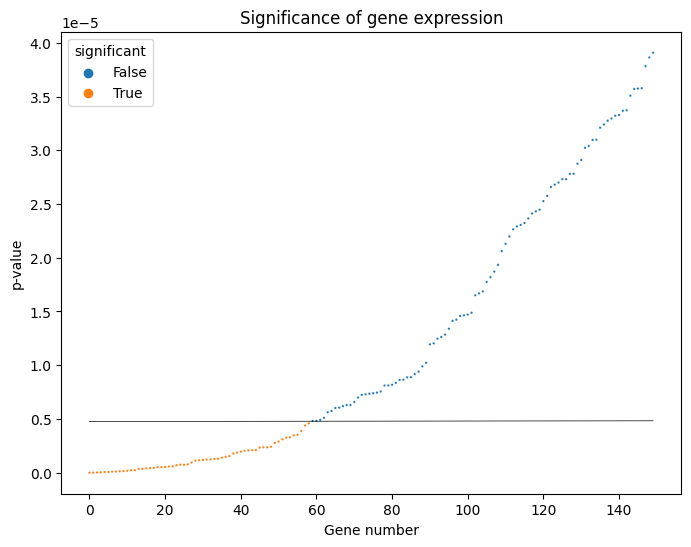

In [93]:
def plot_significance(results, threshold):
    results['number'] = range(len(results))
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x='number',y=threshold, data=results, ax=ax, color='black', linewidth=0.5)
    sns.scatterplot(x='number',y='p_value', hue='significant', data=results, s=3, ax=ax)
    ax.set_title('Significance of gene expression')
    ax.set_xlabel('Gene number')
    ax.set_ylabel('p-value')
    
plot_significance(holms_results.iloc[:150,:].copy(), 'holms_threshold')    

Notice the following about this plot:  
1. The p-value significance line crosses the threshold point at an apparent break point.   
2. The significant p-values are all very small since there are so many tests.
3. The Holm's threshold is does not change very much over the first 150 test results. 

### Benamini-Hochberg FDR Control 

The Benamini-Hochberg FDR control algorithm is another way to control false discoveries. Stat with an ordered set of $n$ p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$ we define a false discovery rate, $q$:

$$FDR(D) \le q$$

The cutoff threshold for the ith p-value is then:
$$p_{(i)} \le Threshold(D_q) = \frac{q}{n} i$$

> **Exercise 01-9:** In this exercise you will apply the Benamini-Hochberg FDR control algorithm for testing the significance of the gene expressions. The `BH_significance` function is quite similar to the Holm's method function you have already created. Given the large number of genes you must use a low false discovery rate, $0.001$, or 1 out of 1,000. 
> Execute your function, saving the result. Then print the number of significant cases. 

In [80]:
np.divide((0.001 * np.array(range(1, 10497 + 1))),  10497)

array([9.52653139e-08, 1.90530628e-07, 2.85795942e-07, ...,
       9.99809469e-04, 9.99904735e-04, 1.00000000e-03])

In [73]:
def BH_significance(test_results, false_discovery_tollerance):
    ## First compute the thresholds for each of the ordered tests
    ## Put your code below. 
    N = test_results.shape[0]
    test_results['bh_threshold'] = np.divide((false_discovery_tollerance * np.array(range(1, N + 1))), N)
    test_results['significant'] = np.array(test_results['p_value'] <= test_results['bh_threshold'])    
   

    return test_results

BH_results = BH_significance(gene_statistics, 0.001)    
len(BH_results.loc[BH_results.loc[:,'significant'],:])

71

> This result differs from the first two FDR control methods you have applied. Given the false discovery parameter of 0.001 do you think this is a reasonable result and why? 

> **Answer:** This, this is a reasonable result. First, we expect that the BH method may allow us to avoid more type II errors than the previous methods, so it may lead to more real discoveries. Second, however, is the size of our dataset, about 10,000 genes. Given a  1 in 1000 false discovery rate, we could expect about 10 false discoveries for our dataset, which is about what the increase in significant results over the first two methods (Bonferroni and Holm) is. 

Finally, execute the code in the cell below and examine the resulting plot.

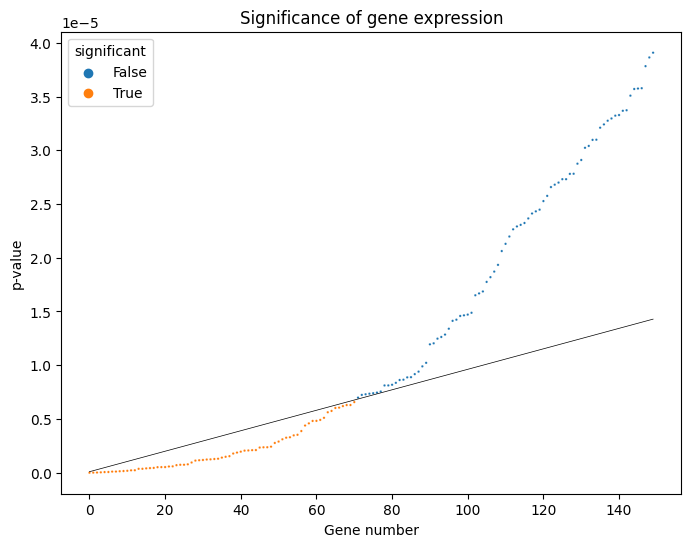

In [78]:
plot_significance(BH_results.iloc[:150,:].copy(), 'bh_threshold')    

> **Exercise 01-10**: Compare the plots of results of the Benamini-Hochberg FDR control method to those of Holm's method. Why does the Benamini-Hochberg FDR control method give a more dynamic or adaptive result for the case where $i << n$? 

> **Answer:** The slope of the threshold for the Holm method can be calculated by taking the derivative as a function of i (approximating i as a continuous variable). The derivative ends up being alpha / (N - i + 1)^2, so for small i the derivative, or slope, as a function of i is approximately zero. This means that this the threshold for low i is not very dynamic in the Holm method.
>
> The BH method, in contrast, has a constant slope of q/N, even at low i. This makes the BH method hae a more dynamic threshold for i << N

##### Copyright 2021, 2022, 2023, Stephen F. Elston. All rights reserved. 